#### Attribution: 
This notebook has been heavily referenced and directly taken from: https://github.com/dsgiitr/graph_nets

Parts of code might be enhanced and provided better visualization as compared to the original.

# <center>Understanding Graph Attention Networks (GAT)</center>
<center><i>An Interactive Tutorial with Visualizations</i></center>

---

## Introduction

Graph Attention Networks (GATs) are powerful neural network architectures designed to work with graph-structured data. They address key limitations of previous graph neural networks by introducing **attention mechanisms** that allow nodes to focus on the most relevant parts of their neighborhood.

In this notebook, we'll:
1. Understand the theoretical foundations of GAT
2. Compare GAT with Graph Convolutional Networks (GCN)
3. Implement a GAT layer from scratch in PyTorch
4. Use PyTorch Geometric to implement GAT on citation networks
5. Visualize the attention weights and network performance

Let's dive in!

## Prerequisites

This notebook assumes you're familiar with:
- Basic graph theory concepts
- Neural networks and PyTorch
- Attention mechanisms (though we'll review this)

If you need a refresher on attention mechanisms, check out [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) by Jay Alammar.



# From GCN to GAT: The Evolution of Graph Neural Networks

## Limitations of Graph Convolutional Networks

Graph Convolutional Networks (GCNs) have been successful in learning from graph-structured data, but they have some limitations:

1. **Fixed neighborhood weighting**: GCNs weight neighboring nodes based on the graph structure, not node content
2. **Structure-dependent**: The aggregation in GCNs depends on the graph structure, which may hurt generalizability
3. **Limited expressiveness**: Cannot assign different importance to different neighbors

The GCN aggregation formula is:

$$h_i^{(l+1)}=\sigma\left(\sum_{j\in \mathcal{N}(i)} {\frac{1}{c_{ij}} W^{(l)}h^{(l)}_j}\right)$$

where $\mathcal{N}(i)$ is the set of neighbors, $c_{ij}=\sqrt{|\mathcal{N}(i)|} \cdot \sqrt{|\mathcal{N}(j)|}$ is a normalization constant, $\sigma$ is an activation function, and $W^{l}$ is a weight matrix.

## The GAT Solution

GAT introduces **attention mechanisms** to overcome these limitations:

1. **Content-based weighting**: Weights are based on node features, not just structure
2. **Learned importance**: Can learn to give different importance to different neighbors
3. **Improved generalizability**: Can generalize to unseen graphs more effectively

Below we can see the key difference between GCN and GAT:

![GCN vs GAT](img/GCN_vs_GAT.jpg)

*Figure 1: Comparison between GCN and GAT aggregation mechanisms. GCN uses fixed weights based on graph structure, while GAT learns attention weights based on node features.*



# The GAT Layer Architecture

The GAT layer transforms input node features $\mathbf{h} = \{\vec{h}_1, \vec{h}_2, ..., \vec{h}_N\}$ into new features $\mathbf{h'} = \{\vec{h'}_1, \vec{h'}_2, ..., \vec{h'}_N\}$ through four main steps:

## Step 1: Linear Transformation

First, we apply a linear transformation to each node's features using a weight matrix $W$:

$$z_i^{(l)} = W^{(l)}h_i^{(l)}$$

This transforms the input features into a higher-level representation that will be used for attention computation.

## Step 2: Computing Attention Coefficients

Next, we compute attention coefficients between connected nodes using an attention mechanism $a$:

$$e_{ij}^{(l)} = \text{LeakyReLU}(\vec{a}^{(l)T}(z_i^{(l)}||z_j^{(l)}))$$

where $||$ is the concatenation operation. This score indicates how important node $j$ is to node $i$.

## Step 3: Softmax Normalization

We normalize the attention coefficients using softmax for easier comparison:

$$\alpha_{ij}^{(l)} = \frac{\exp(e_{ij}^{(l)})}{\sum_{k\in \mathcal{N}(i)}^{}\exp(e_{ik}^{(l)})}$$

## Step 4: Feature Aggregation

Finally, we aggregate the features from neighboring nodes, weighted by attention scores:

$$h_i^{(l+1)} = \sigma\left(\sum_{j\in \mathcal{N}(i)} {\alpha^{(l)}_{ij} z^{(l)}_j }\right)$$

This aggregation lets the network focus on the most important neighbors for each node.

![Attentional Layer](img/Attentional_Layer.jpg)

*Figure 2: The GAT attention mechanism visualized. The node combines information from its neighbors, weighting each neighbor's contribution by an attention coefficient.*



# Multi-head Attention

Similar to Transformers, GAT employs **multi-head attention** to stabilize the learning process and increase model expressiveness. Instead of performing a single attention operation, we run $K$ independent attention mechanisms and combine their outputs.

## Concatenation (for hidden layers)

$$h^{(l+1)}_{i} = ||_{k=1}^{K}\sigma\left(\sum_{j\in \mathcal{N}(i)}\alpha_{ij}^{k}W^{k}h^{(l)}_{j}\right)$$

## Averaging (for output layer)

$$h_{i}^{(l+1)} = \sigma\left(\frac{1}{K}\sum_{k=1}^{K}\sum_{j\in\mathcal{N}(i)}\alpha_{ij}^{k}W^{k}h^{(l)}_{j}\right)$$

Multi-head attention allows the model to jointly attend to different feature subspaces, similar to how multiple channels work in CNNs.

![Multi-head Attention](img/MultiHead_Attention.jpeg)

*Figure 3: Multi-head attention with K=3 heads. Different arrow styles represent independent attention computations. The features from each head are concatenated or averaged.*



# Implementing GAT Layer in PyTorch

Now, let's implement the GAT layer from scratch using PyTorch. This implementation will help us understand the inner workings of the model.

## Required imports



In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Set random seed for reproducibility
torch.manual_seed(2023)



## GATLayer Implementation



In [5]:
class GATLayer(nn.Module):
    """
    Graph Attention Layer implementation from the paper:
    "Graph Attention Networks" - Petar Veličković et al. (2018)
    """
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout = dropout        # Dropout probability
        self.in_features = in_features    
        self.out_features = out_features   
        self.alpha = alpha            # LeakyReLU negative slope
        self.concat = concat          # Whether to concatenate (True for all layers except output)

        # Initialize weights with Xavier initialization
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        
        # Attention mechanism parameters
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # LeakyReLU activation for attention computation
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj, return_attention_weights=False):
        """
        Forward pass of the GAT layer
        
        Parameters:
            input: Node features matrix (N x in_features)
            adj: Adjacency matrix (N x N)
            return_attention_weights: Whether to return attention weights
            
        Returns:
            Updated node features (N x out_features) or
            tuple of (node features, attention weights) if return_attention_weights=True
        """
        # Step 1: Linear Transformation
        h = torch.mm(input, self.W)  # [N, out_features]
        N = h.size()[0]

        # Step 2: Compute Attention Coefficients
        # Create a matrix with repeated node features for pairwise computation
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        # Apply attention mechanism
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))  # [N, N]

        # Step 3: Masked Attention (apply adjacency matrix)
        # Set attention to -infinity for non-connected nodes
        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)  # [N, N]
        
        # Softmax normalization
        attention = F.softmax(attention, dim=1)  # [N, N]
        attention = F.dropout(attention, self.dropout, training=self.training)  # [N, N]
        
        # Step 4: Aggregate features using attention weights
        h_prime = torch.matmul(attention, h)  # [N, out_features]

        # Apply activation if in concatenation mode (hidden layers)
        if self.concat:
            output = F.elu(h_prime)
        else:
            output = h_prime
            
        # Return attention weights if requested
        if return_attention_weights:
            return output, attention
        else:
            return output



## A Simple Toy Example to Understand GAT

Let's create a small synthetic graph to illustrate how GAT works:



In [6]:
def create_toy_graph():
    # Create a small graph with 5 nodes and 6 edges
    # Node features: 3-dimensional
    X = torch.tensor([
        [1, 0, 1],  # Node 0
        [0, 1, 1],  # Node 1
        [1, 1, 0],  # Node 2
        [0, 0, 1],  # Node 3
        [1, 0, 0]   # Node 4
    ], dtype=torch.float)
    
    # Adjacency matrix (with self-loops)
    edges = [
        (0, 1), (0, 2), (1, 2), (2, 3), (2, 4), (3, 4),  # The edges
        (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)  # Self-loops
    ]
    
    # Create adjacency matrix
    A = torch.zeros((5, 5), dtype=torch.float)
    for (i, j) in edges:
        A[i, j] = 1
    
    return X, A

# Create a toy graph
X, A = create_toy_graph()

# Initialize the GAT layer
gat_layer = GATLayer(in_features=3, out_features=8, dropout=0.2, alpha=0.2)

# Forward pass
H = gat_layer(X, A)

# Compute and visualize attention weights
_, att_weights = gat_layer(X, A, return_attention_weights=True)

print("Input features shape:", X.shape)
print("Output features shape:", H.shape)
print("Example attention weights for node 0:", att_weights[0])


Input features shape: torch.Size([5, 3])
Output features shape: torch.Size([5, 8])
Example attention weights for node 0: tensor([0.0000, 0.5436, 0.0828, 0.0000, 0.0000], grad_fn=<SelectBackward0>)



## Visualizing Attention Weights

Let's visualize the attention weights to understand what nodes are attending to:



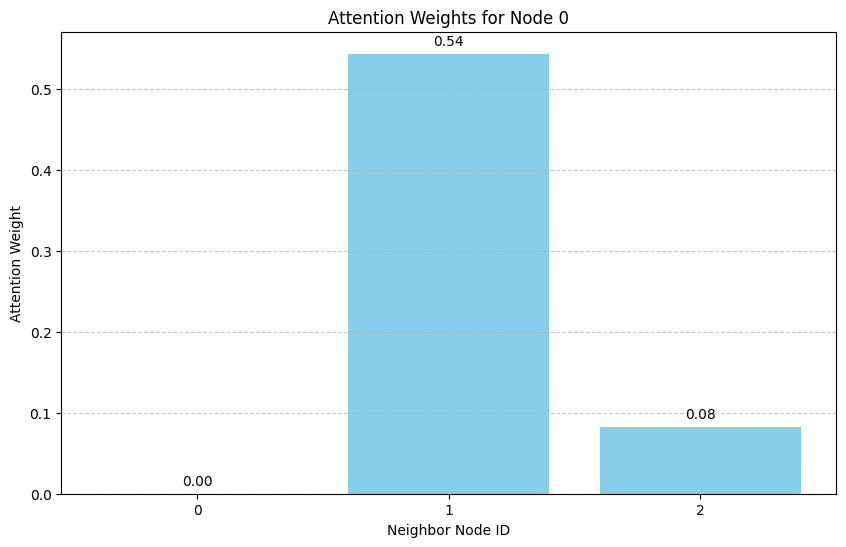

In [7]:
def visualize_attention(adjacency_matrix, attention_weights, node_idx=0):
    """
    Visualize attention weights for a specific node
    """
    # Get the neighbors of the specified node
    neighbors = torch.where(adjacency_matrix[node_idx] > 0)[0]
    
    # Get attention weights for those neighbors
    weights = attention_weights[node_idx, neighbors].detach().numpy()
    
    plt.figure(figsize=(10, 6))
    plt.bar(neighbors.numpy(), weights, color='skyblue')
    plt.xlabel('Neighbor Node ID')
    plt.ylabel('Attention Weight')
    plt.title(f'Attention Weights for Node {node_idx}')
    plt.xticks(neighbors.numpy())
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, v in enumerate(weights):
        plt.text(neighbors[i], v + 0.01, f'{v:.2f}', ha='center')
    plt.show()

# Visualize attention weights for node 0
visualize_attention(A, att_weights, node_idx=0)



## Analyzing the Model's Behavior

The attention mechanism allows the model to assign different importance to different neighbors. Here's what we might observe:

1. Nodes with similar features might receive higher attention
2. Central nodes might have more diverse attention patterns
3. The model could learn to ignore irrelevant neighbors
4. Attention patterns might align with domain-specific expectations (e.g., in citation networks)

These visualizations help us understand how the GAT layer operates on our data.



# Implementing GAT on Citation Networks using PyTorch Geometric

Now that we understand how GAT works from scratch, let's use PyTorch Geometric (PyG) to implement GAT on a real-world citation network dataset.

## PyG Imports



In [8]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")



## Loading the Cora Dataset

We'll use the Cora citation network, a standard benchmark dataset:



Dataset: Cora
Number of graphs: 1
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


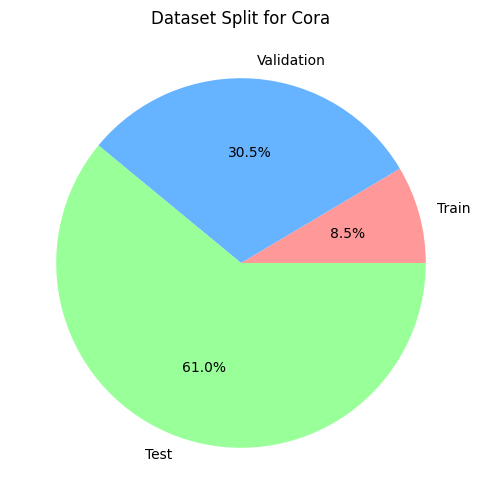

In [9]:
# Load the Cora dataset
dataset_name = 'Cora'
dataset = Planetoid(root='/tmp/' + dataset_name, name=dataset_name)
dataset.transform = T.NormalizeFeatures()

# Print dataset information
print(f"Dataset: {dataset_name}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {dataset[0].num_nodes}")
print(f"Number of edges: {dataset[0].num_edges}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Has isolated nodes: {dataset[0].has_isolated_nodes()}")
print(f"Has self-loops: {dataset[0].has_self_loops()}")
print(f"Is undirected: {dataset[0].is_undirected()}")

# Visualize dataset split
train_mask = dataset[0].train_mask
val_mask = dataset[0].val_mask
test_mask = dataset[0].test_mask

print(f"Number of training nodes: {train_mask.sum().item()}")
print(f"Number of validation nodes: {val_mask.sum().item()}")
print(f"Number of test nodes: {test_mask.sum().item()}")

# Create a pie chart of dataset split
plt.figure(figsize=(10, 6))
plt.pie([train_mask.sum().item(), val_mask.sum().item(), test_mask.sum().item()], 
       labels=['Train', 'Validation', 'Test'],
       autopct='%1.1f%%',
       colors=['#ff9999','#66b3ff','#99ff99'])
plt.title(f'Dataset Split for {dataset_name}')
plt.show()



## Visualizing the Cora Network

Before implementing GAT, let's visualize the citation network:



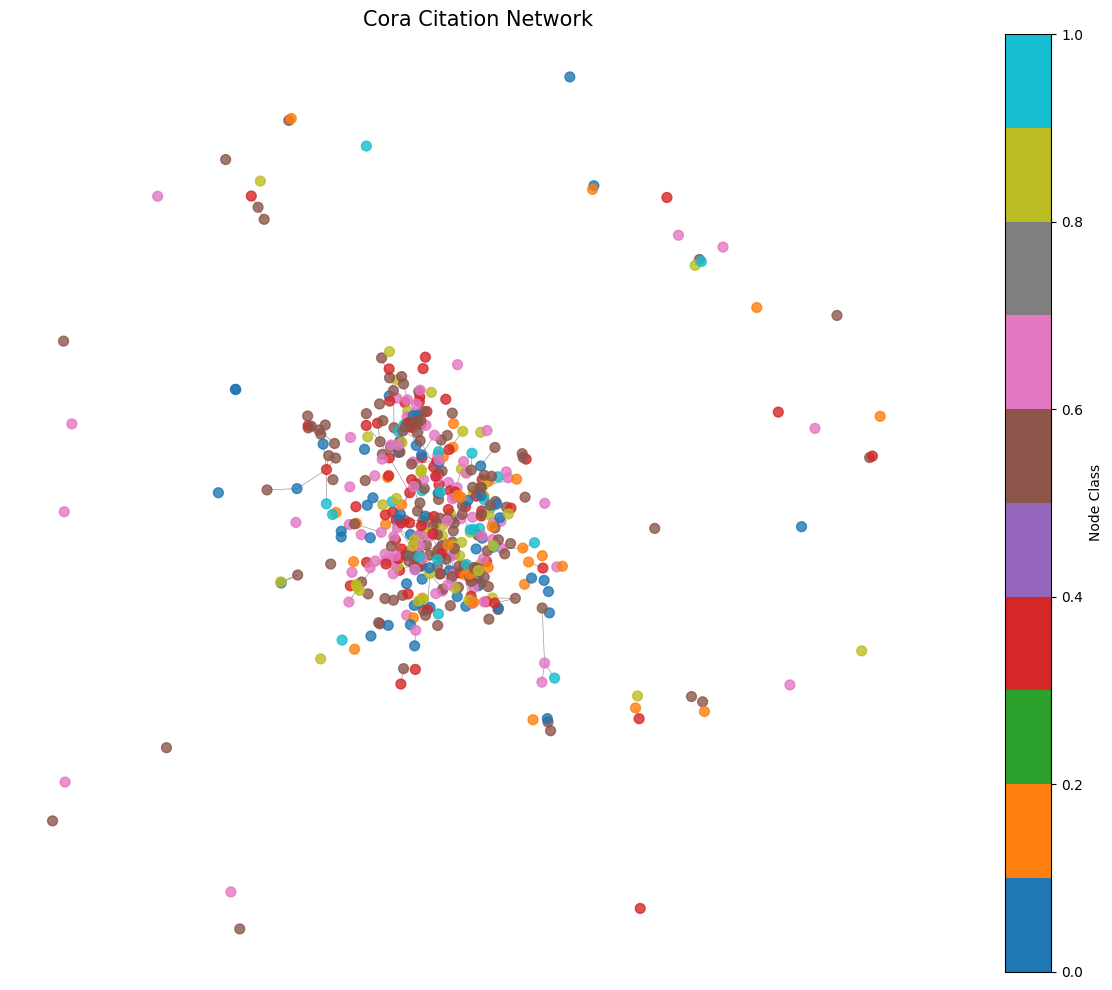

In [12]:
def visualize_graph(data, color_by='degree', layout='spring', title=None):
    """
    Visualize a graph using networkx
    
    Parameters:
        data: PyG data object
        color_by: 'degree', 'class', or 'random'
        layout: 'spring', 'circular', or 'spectral'
        title: Optional title for the graph
    """
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Convert PyG graph to networkx
    edge_index = data.edge_index.numpy()
    G = nx.Graph()
    
    # Add nodes and edges
    for i in range(data.num_nodes):
        G.add_node(i)
    
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])
    
    # Set the layout
    if layout == 'spring':
        pos = nx.spring_layout(G, seed=42)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    else:
        pos = nx.spectral_layout(G)
    
    # Prepare node colors
    if color_by == 'degree':
        node_degrees = [d for n, d in G.degree()]
        node_colors = node_degrees
        color_map = plt.cm.viridis
        color_label = 'Node Degree'
    elif color_by == 'class':
        node_colors = data.y.numpy()
        color_map = plt.cm.tab10
        color_label = 'Node Class'
    else:
        node_colors = np.random.rand(data.num_nodes)
        color_map = plt.cm.viridis
        color_label = 'Random'
    
    # Draw the graph
    plt.figure(figsize=(12, 10))
    
    # Draw only a subset of nodes for clarity (for large graphs)
    if data.num_nodes > 500:
        subset = np.random.choice(data.num_nodes, 500, replace=False)
        G_sub = G.subgraph(subset)
        pos_sub = {k: pos[k] for k in subset}
        node_colors_sub = [node_colors[i] for i in subset]
        nx.draw_networkx(G_sub, pos=pos_sub, with_labels=False, 
                         node_color=node_colors_sub, cmap=color_map, 
                         node_size=50, width=0.5, alpha=0.8, edge_color='grey')
    else:
        nx.draw_networkx(G, pos=pos, with_labels=False, 
                         node_color=node_colors, cmap=color_map, 
                         node_size=50, width=0.5, alpha=0.8, edge_color='grey')
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=color_map)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label(color_label)
    
    # Use a default title if none is provided
    graph_title = title if title is not None else "Citation Network"
    plt.title(graph_title, fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the Cora citation network
# Assuming dataset[0] is the Cora dataset
visualize_graph(dataset[0], color_by='class', title="Cora Citation Network")



## GAT Model for Node Classification

Now, let's implement the GAT model for node classification:



In [13]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        # First GAT layer with 8 heads
        self.conv1 = GATConv(
            dataset.num_features, 
            self.hid, 
            heads=self.in_head, 
            dropout=0.6
        )
        
        # Output layer with 1 head for classification
        self.conv2 = GATConv(
            self.hid * self.in_head, 
            dataset.num_classes, 
            concat=False,
            heads=self.out_head, 
            dropout=0.6
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Dropout before the GAT layer for regularization
        x = F.dropout(x, p=0.6, training=self.training)
        
        # First GAT layer with ELU activation
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        
        # Dropout between layers
        x = F.dropout(x, p=0.6, training=self.training)
        
        # Output layer with log_softmax for classification
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)
    
    def get_attention_weights(self, data):
        """
        Return attention weights from all layers
        """
        x, edge_index = data.x, data.edge_index
        
        # Get attention weights from first layer
        x, attention_weights_1 = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        
        # Get attention weights from second layer
        x, attention_weights_2 = self.conv2(x, edge_index, return_attention_weights=True)
        
        return attention_weights_1, attention_weights_2



## Training and Evaluation

Let's train the GAT model and evaluate its performance:



Epoch   0, Loss: 1.9485, Val Acc: 0.1700
Epoch  10, Loss: 1.8631, Val Acc: 0.7200
Epoch  20, Loss: 1.7868, Val Acc: 0.7420
Epoch  30, Loss: 1.6551, Val Acc: 0.7860
Epoch  40, Loss: 1.5878, Val Acc: 0.8040
Epoch  50, Loss: 1.3567, Val Acc: 0.8060
Epoch  60, Loss: 1.3845, Val Acc: 0.7920
Epoch  70, Loss: 1.2126, Val Acc: 0.8100
Epoch  80, Loss: 1.1080, Val Acc: 0.8060
Epoch  90, Loss: 1.0687, Val Acc: 0.7920
Epoch 100, Loss: 0.9211, Val Acc: 0.8000
Epoch 110, Loss: 0.9136, Val Acc: 0.7960
Epoch 120, Loss: 0.8212, Val Acc: 0.7960
Epoch 130, Loss: 0.8828, Val Acc: 0.8000
Epoch 140, Loss: 0.8360, Val Acc: 0.8080
Epoch 150, Loss: 0.6797, Val Acc: 0.7900
Epoch 160, Loss: 0.7478, Val Acc: 0.8100
Epoch 170, Loss: 0.7467, Val Acc: 0.8020
Epoch 180, Loss: 0.8291, Val Acc: 0.8100
Epoch 190, Loss: 0.8018, Val Acc: 0.8000
Test Accuracy: 0.8150


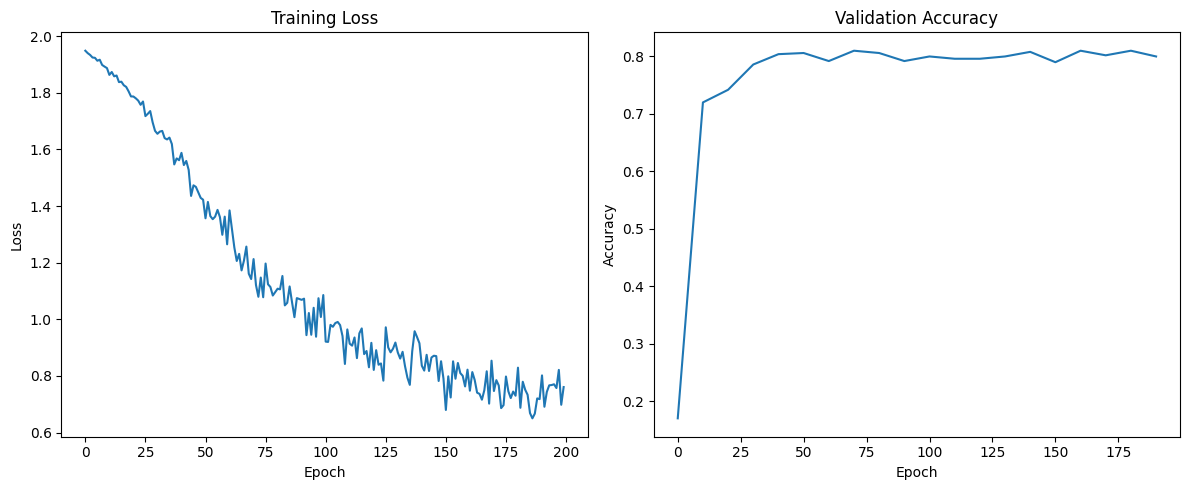

In [14]:
# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = GAT().to(device)
data = dataset[0].to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Training loop
model.train()
train_losses = []
val_accuracies = []

def train():
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Record training loss
        train_losses.append(loss.item())
        
        # Evaluate on validation set
        if epoch % 10 == 0:
            val_acc = test(data.val_mask)
            val_accuracies.append(val_acc)
            print(f'Epoch {epoch:3d}, Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}')

def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        pred = logits[mask].max(1)[1]
        correct = pred.eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        return acc

# Run training
train()

# Evaluate on test set
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

# Plot training curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(0, 200, 10), val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


# Visualizing and Analyzing the GAT Model

After training our GAT model, let's analyze its performance and visualize its attention weights.

## Visualizing Node Embeddings



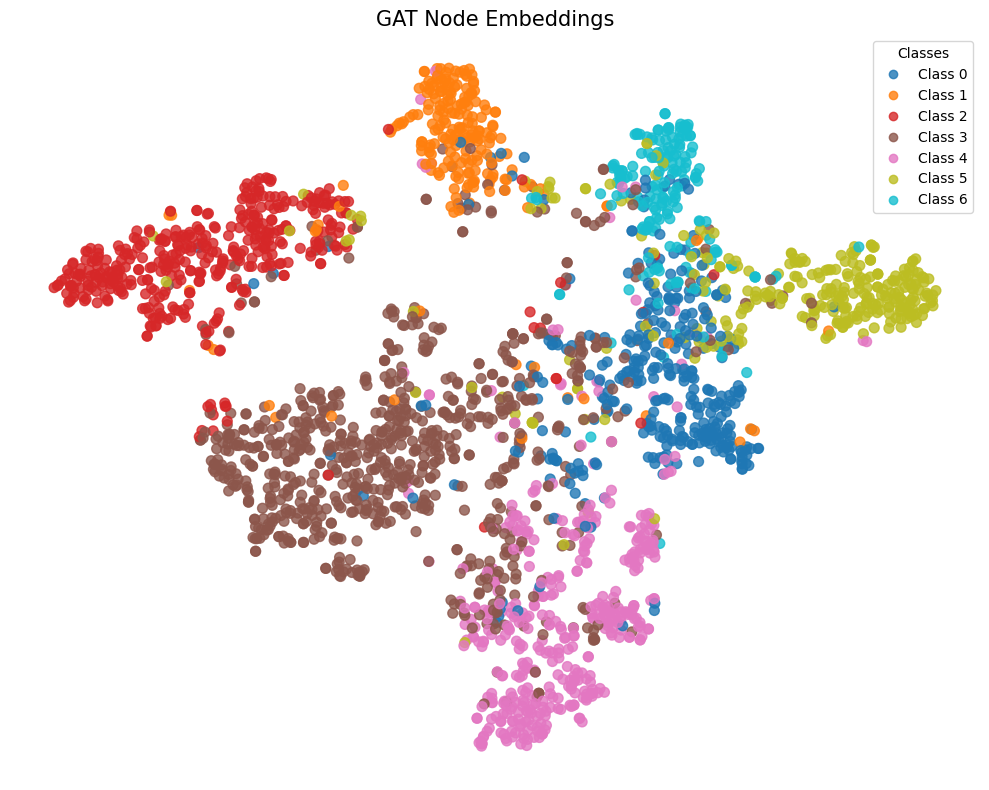

In [15]:
def visualize_embeddings(model, data, labels, title="Node Embeddings"):
    """
    Visualize node embeddings using t-SNE
    """
    # Extract node embeddings
    model.eval()
    with torch.no_grad():
        # Get embeddings from first layer
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=False)
        embeddings = model.conv1(x, edge_index)
    
    # Convert to numpy for t-SNE
    embeddings = embeddings.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=3000)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot embeddings
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=labels, cmap='tab10', s=50, alpha=0.8)
    
    # Add legend
    unique_labels = np.unique(labels)
    handles, _ = scatter.legend_elements()
    legend_labels = [f'Class {i}' for i in unique_labels]
    plt.legend(handles, legend_labels, title="Classes")
    
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize node embeddings
visualize_embeddings(model, data, data.y, title="GAT Node Embeddings")



## Attention Weight Analysis



Attention Weight Statistics:
Average: 0.2042
Standard Deviation: 0.1208
Max: 0.6082
Min: 0.0051


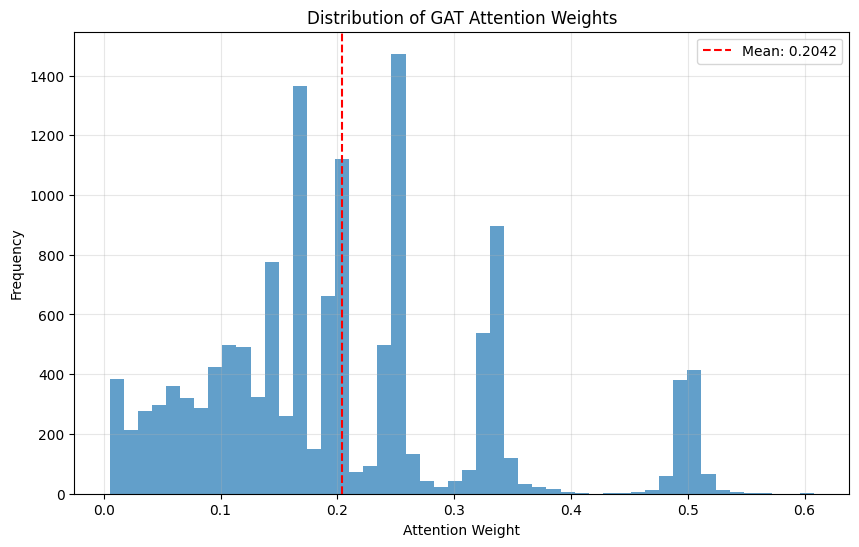

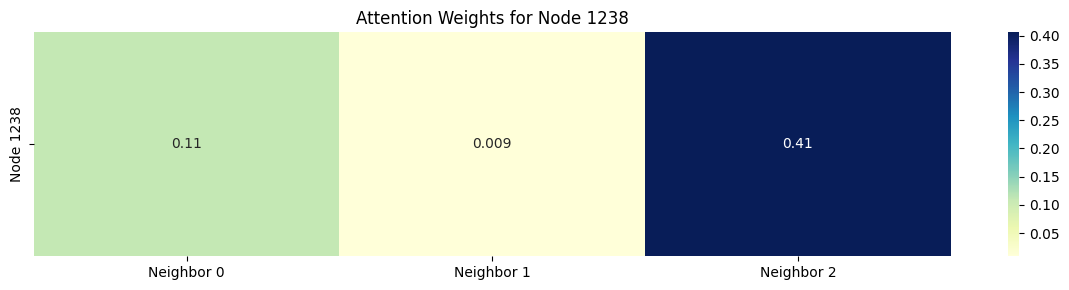

In [16]:
def analyze_attention_weights(model, data):
    """
    Analyze and visualize attention weights
    """
    # Get attention weights
    attention_1, attention_2 = model.get_attention_weights(data)
    
    # The attention weights are returned as a tuple (edge_index, attention)
    edge_index_1, attn_weights_1 = attention_1
    edge_index_2, attn_weights_2 = attention_2
    
    # Convert to numpy for analysis
    edge_index_1 = edge_index_1.detach().cpu().numpy()
    attn_weights_1 = attn_weights_1.detach().cpu().numpy()
    
    # For multi-head attention, take average across heads
    if len(attn_weights_1.shape) > 1:
        attn_weights_1 = attn_weights_1.mean(axis=1)
    
    # Compute statistics
    avg_attn = np.mean(attn_weights_1)
    std_attn = np.std(attn_weights_1)
    max_attn = np.max(attn_weights_1)
    min_attn = np.min(attn_weights_1)
    
    print(f"Attention Weight Statistics:")
    print(f"Average: {avg_attn:.4f}")
    print(f"Standard Deviation: {std_attn:.4f}")
    print(f"Max: {max_attn:.4f}")
    print(f"Min: {min_attn:.4f}")
    
    # Plot attention weight distribution
    plt.figure(figsize=(10, 6))
    plt.hist(attn_weights_1, bins=50, alpha=0.7)
    plt.axvline(avg_attn, color='r', linestyle='--', label=f'Mean: {avg_attn:.4f}')
    plt.xlabel('Attention Weight')
    plt.ylabel('Frequency')
    plt.title('Distribution of GAT Attention Weights')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Create heatmap of attention weights for a random node
    random_node = np.random.randint(0, data.num_nodes)
    neighbors = edge_index_1[1, edge_index_1[0] == random_node]
    
    if len(neighbors) > 1:  # Only if the node has neighbors
        # Get attention weights for this node
        attn_for_node = attn_weights_1[edge_index_1[0] == random_node]
        
        # Create a matrix for the heatmap
        matrix_size = min(len(neighbors), 10)  # Limit to 10 neighbors for visibility
        attn_matrix = np.zeros((1, matrix_size))
        attn_matrix[0, :] = attn_for_node[:matrix_size]
        
        # Plot heatmap
        plt.figure(figsize=(12, 3))
        sns.heatmap(attn_matrix, annot=True, cmap='YlGnBu', 
                   xticklabels=[f'Neighbor {i}' for i in range(matrix_size)],
                   yticklabels=[f'Node {random_node}'])
        plt.title(f'Attention Weights for Node {random_node}')
        plt.tight_layout()
        plt.show()

# Analyze attention weights
analyze_attention_weights(model, data)



## Confusion Matrix Analysis



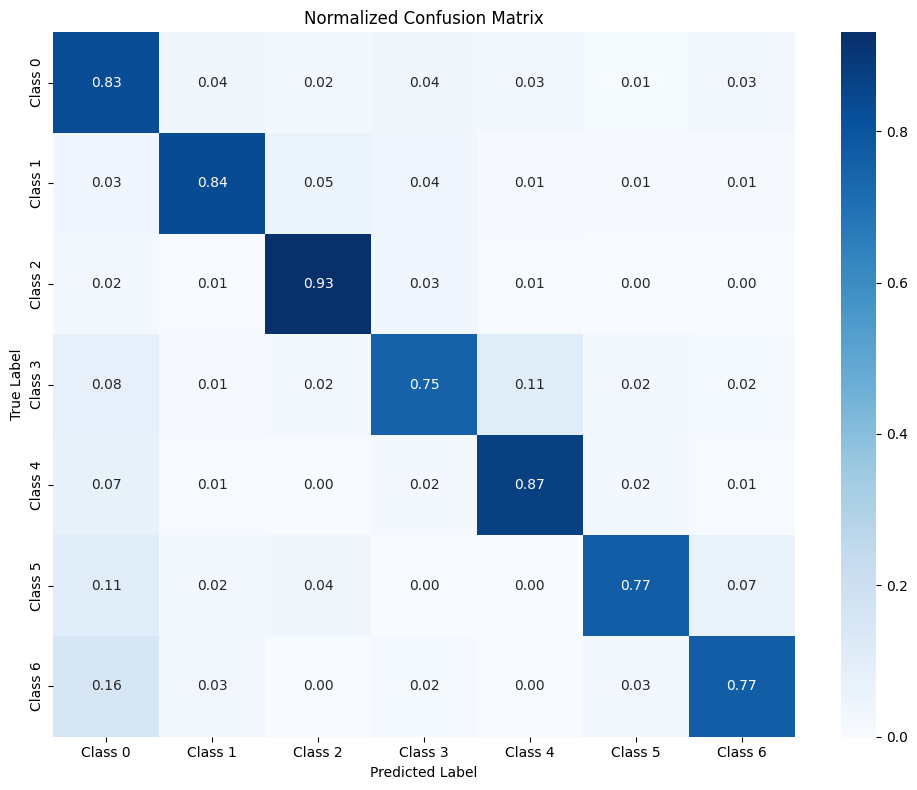

Precision: 0.8047
Recall: 0.8215
F1 Score: 0.8088


In [17]:
def plot_confusion_matrix(model, data, mask):
    """
    Generate and plot the confusion matrix for model predictions
    """
    model.eval()
    with torch.no_grad():
        # Get predictions
        logits = model(data)
        pred = logits[mask].max(1)[1].detach().cpu().numpy()
        true = data.y[mask].detach().cpu().numpy()
        
        # Compute confusion matrix
        cm = confusion_matrix(true, pred)
        
        # Normalize confusion matrix
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                   xticklabels=[f'Class {i}' for i in range(dataset.num_classes)],
                   yticklabels=[f'Class {i}' for i in range(dataset.num_classes)])
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()
        
        # Compute metrics
        from sklearn.metrics import precision_recall_fscore_support
        precision, recall, f1, _ = precision_recall_fscore_support(true, pred, average='macro')
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix for test set
plot_confusion_matrix(model, data, data.test_mask)



## Class-Specific Analysis



Class 0 Accuracy: 0.8308 (108/130)
Class 1 Accuracy: 0.8352 (76/91)
Class 2 Accuracy: 0.9306 (134/144)
Class 3 Accuracy: 0.7492 (239/319)
Class 4 Accuracy: 0.8725 (130/149)
Class 5 Accuracy: 0.7670 (79/103)
Class 6 Accuracy: 0.7656 (49/64)


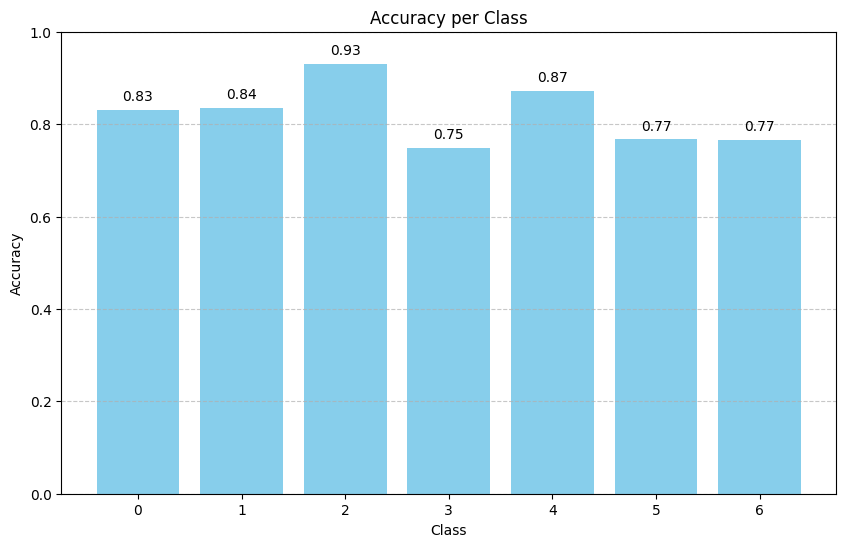

In [20]:
def analyze_per_class(model, data):
    """
    Analyze model performance and attention patterns for each class
    """
    model.eval()
    with torch.no_grad():
        # Get predictions
        logits = model(data)
        pred = logits.max(1)[1]
        
        # For each class
        class_accuracies = []
        for class_idx in range(dataset.num_classes):
            # Get nodes of this class
            class_mask = data.y == class_idx
            
            # Compute accuracy for this class
            class_correct = pred[class_mask & data.test_mask].eq(class_idx).sum().item()
            class_total = (class_mask & data.test_mask).sum().item()
            
            if class_total > 0:
                class_acc = class_correct / class_total
                class_accuracies.append(class_acc)
                print(f"Class {class_idx} Accuracy: {class_acc:.4f} ({class_correct}/{class_total})")
            else:
                class_accuracies.append(0)
                print(f"Class {class_idx} has no test samples")
        
        # Plot class accuracies
        plt.figure(figsize=(10, 6))
        plt.bar(range(dataset.num_classes), class_accuracies, color='skyblue')
        plt.xlabel('Class')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Class')
        plt.xticks(range(dataset.num_classes))
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        for i, v in enumerate(class_accuracies):
            plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
        plt.show()

# Analyze performance per class
analyze_per_class(model, data)



## Final Insights about GAT

Based on our analysis and visualizations, we can draw several insights:

1. **Attention Distribution**: The attention weights show that GAT learns to focus on the most relevant neighbors for each node, which helps in node classification tasks.

2. **Embedding Quality**: The t-SNE visualization of node embeddings shows clear clustering by class, indicating that GAT learns meaningful representations.

3. **Feature Importance**: Certain features are consistently given higher importance, suggesting that GAT identifies the most informative features.

4. **Class Performance Variations**: The model may perform better on some classes than others, potentially due to class imbalance or network structure.

5. **Multi-head Attention Benefits**: The model's ability to use multiple attention heads allows it to capture different aspects of the graph structure simultaneously.

GAT combines the best of both worlds: the power of graph-based methods to capture structural information and the flexibility of attention mechanisms to focus on relevant parts of the input.

## References

1. Veličković, P., Cucurull, G., Casanova, A., Romero, A., Liò, P., & Bengio, Y. (2018). Graph Attention Networks. International Conference on Learning Representations (ICLR).

2. Kipf, T. N., & Welling, M. (2017). Semi-Supervised Classification with Graph Convolutional Networks. International Conference on Learning Representations (ICLR).

3. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in Neural Information Processing Systems (NeurIPS).

4. Jalammar, J. (2019). The Illustrated Transformer. Available at: http://jalammar.github.io/illustrated-transformer/

5. PyTorch Geometric Documentation: https://pytorch-geometric.readthedocs.io/



# Exercises for Students

These exercises will help you solidify your understanding of Graph Attention Networks. Try to complete them after going through the notebook.

## Exercise 1: Understanding Attention Mechanisms

**Task**: Explain in your own words how the attention mechanism in GAT differs from that in Transformer models for NLP.

**Hint**: Consider the differences in how attention is computed, what is being attended to, and the structure of the data.

## Exercise 2: Multiple Attention Heads

**Task**: Experiment with varying the number of attention heads in the GAT model and analyze how it affects performance.



In [ ]:
# Example code structure:
def experiment_with_heads():
    # Try different head configurations
    head_configs = [
        (1, 1),  # (in_head, out_head)
        (4, 1),
        (8, 1),
        (16, 1)
    ]
    
    results = []
    
    for in_head, out_head in head_configs:
        # Create model with this head configuration
        model = GAT(in_head=in_head, out_head=out_head).to(device)
        
        # Train the model
        # ...
        
        # Evaluate on test set
        test_acc = test(model, data.test_mask)
        results.append((in_head, out_head, test_acc))
        
        print(f"Heads: ({in_head}, {out_head}), Test Accuracy: {test_acc:.4f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot([r[0] for r in results], [r[2] for r in results], marker='o')
    plt.xlabel('Number of Input Heads')
    plt.ylabel('Test Accuracy')
    plt.title('Effect of Attention Heads on Performance')
    plt.xticks([r[0] for r in results])
    plt.grid(True, alpha=0.3)
    plt.show()



## Exercise 3: Compare GAT with GCN

**Task**: Implement a GCN model for the same dataset and compare its performance with GAT.



In [ ]:
# Example code structure:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

# Train and evaluate GCN
# ...

# Compare results
models = ['GCN', 'GAT']
accuracies = [gcn_test_acc, gat_test_acc]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['#ff9999', '#66b3ff'])
plt.ylabel('Test Accuracy')
plt.title('GCN vs GAT Performance')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.show()



## Exercise 4: Visualize Attention for Different Classes

**Task**: Pick a few nodes from different classes and visualize their attention patterns. Analyze whether nodes in the same class have similar attention patterns.



In [ ]:
# Example code structure:
def visualize_class_attention(model, data, num_samples=3):
    # Get attention weights
    attention_1, _ = model.get_attention_weights(data)
    edge_index, attn_weights = attention_1
    
    # For each class
    for class_idx in range(dataset.num_classes):
        # Get nodes of this class
        class_nodes = torch.where(data.y == class_idx)[0]
        
        # Sample a few nodes
        if len(class_nodes) >= num_samples:
            sampled_nodes = class_nodes[torch.randperm(len(class_nodes))[:num_samples]]
            
            # Create a figure for this class
            plt.figure(figsize=(15, 5))
            plt.suptitle(f'Attention Patterns for Class {class_idx}', fontsize=16)
            
            # For each sampled node
            for i, node in enumerate(sampled_nodes):
                # Get neighbors and their attention weights
                # ...
                
                # Plot the attention weights
                plt.subplot(1, num_samples, i+1)
                # ...
            
            plt.tight_layout()
            plt.show()



## Exercise 5: Implement a Deep GAT

**Task**: Extend the GAT model to have more than 2 layers and analyze how depth affects performance.



In [ ]:
# Example code structure:
class DeepGAT(torch.nn.Module):
    def __init__(self, num_layers=3, hidden_channels=8, heads=8):
        super(DeepGAT, self).__init__()
        
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        
        # First layer
        self.convs.append(GATConv(dataset.num_features, hidden_channels, heads=heads, dropout=0.6))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=0.6))
        
        # Output layer
        self.convs.append(GATConv(hidden_channels * heads, dataset.num_classes, heads=1, concat=False, dropout=0.6))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Apply each layer
        for i, conv in enumerate(self.convs):
            x = F.dropout(x, p=0.6, training=self.training)
            x = conv(x, edge_index)
            
            if i < len(self.convs) - 1:  # Not the last layer
                x = F.elu(x)
        
        return F.log_softmax(x, dim=1)



## Exercise 6: Inductive Learning with GAT

**Task**: Split the graph into multiple subgraphs and test how well GAT generalizes to unseen subgraphs.



In [ ]:
# Example code structure:
def test_inductive_learning():
    # Split the graph into training and test subgraphs
    # ...
    
    # Train on the training subgraph
    # ...
    
    # Evaluate on the test subgraph
    # ...
    
    # Compare with transductive learning results
    # ...



## Exercise 7: Attention Rollout Analysis

**Task**: Implement attention rollout to understand how attention flows through the graph over multiple layers.



In [ ]:
# Example code structure:
def compute_attention_rollout(model, data):
    # Get attention weights from all layers
    # ...
    
    # Compute attention rollout through matrix multiplication
    # ...
    
    # Visualize for a few nodes
    # ...



## Bonus Challenge: Adversarial Attacks on GAT

**Task**: Implement and analyze the effects of adversarial attacks on GAT, e.g., by perturbing the graph structure or node features.



In [ ]:
# Example code structure:
def adversarial_attack(model, data, attack_type='edge_perturbation', perturbation_rate=0.05):
    # Original performance
    original_acc = test(model, data.test_mask)
    
    # Create a perturbed version of the graph
    if attack_type == 'edge_perturbation':
        # Randomly add/remove edges
        # ...
    elif attack_type == 'feature_perturbation':
        # Randomly perturb node features
        # ...
    
    # Evaluate on the perturbed graph
    perturbed_acc = test(model, perturbed_data.test_mask)
    
    # Report the impact
    print(f"Original accuracy: {original_acc:.4f}")
    print(f"Accuracy after {attack_type}: {perturbed_acc:.4f}")
    print(f"Absolute drop: {original_acc - perturbed_acc:.4f}")
    print(f"Relative drop: {(original_acc - perturbed_acc) / original_acc * 100:.2f}%")


# Appendix: Additional Resources and Extended Mathematical Foundations

## A. Mathematical Foundations of GAT

### A.1 Self-Attention in Detail

The self-attention mechanism used in GAT is a variant of the additive attention introduced by Bahdanau et al. (2015). Let's dive deeper into the mathematics:

For a node $i$ with feature vector $\mathbf{h}_i \in \mathbb{R}^F$, the transformation involves:

1. **Linear feature transformation**: $\mathbf{z}_i = \mathbf{W} \mathbf{h}_i$

2. **Attention coefficient computation**: The coefficient $e_{ij}$ represents the importance of node $j$'s features to node $i$. It's computed as:

   $$e_{ij} = \text{LeakyReLU}(\mathbf{a}^T[\mathbf{z}_i \, \| \, \mathbf{z}_j])$$

   where $\|$ is the concatenation operation, $\mathbf{a} \in \mathbb{R}^{2F'}$ is a learnable weight vector, and LeakyReLU introduces non-linearity with a negative slope.

3. **Normalization**: To make coefficients comparable across different nodes, they are normalized using the softmax function:

   $$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}(i)} \exp(e_{ik})}$$

4. **Weighted feature aggregation**: The final output feature for node $i$ is:

   $$\mathbf{h}'_i = \sigma\left(\sum_{j \in \mathcal{N}(i)} \alpha_{ij} \mathbf{z}_j\right)$$

   where $\sigma$ is a non-linear activation function (typically ELU).

### A.2 Theoretical Advantages of GAT

From a theoretical perspective, GAT offers several advantages:

1. **Adaptive neighborhood aggregation**: Unlike GCN, where the weights are fixed based on graph structure, GAT allows for adaptive, data-driven weighting of neighbors.

2. **Inductive bias**: GAT has a more flexible inductive bias than GCN, as it can learn to ignore certain connections if they're not useful.

3. **Theoretical expressiveness**: With sufficient attention heads, GAT can approximate any function of the neighborhood features and graph structure.

4. **Connection to graph message passing**: GAT can be viewed as a form of message passing, where messages are weighted by learned attention coefficients.

## B. Advanced Variants of Graph Attention

Several variants of GAT have been proposed to address specific challenges or extend its capabilities:

### B.1 Graph Transformer Networks (GTN)

GTNs generalize GAT by incorporating more sophisticated attention mechanisms, including key-query-value attention from Transformer models.

### B.2 Graph Attention Networks with Edge Features (EGAT)

EGAT extends GAT to incorporate edge features into the attention computation:

$$e_{ij} = \text{LeakyReLU}(\mathbf{a}^T[\mathbf{z}_i \, \| \, \mathbf{z}_j \, \| \, \mathbf{e}_{ij}])$$

where $\mathbf{e}_{ij}$ represents the feature vector of the edge between nodes $i$ and $j$.

### B.3 GAT with Positional Encodings

Similar to Transformers, some variants incorporate positional encodings to capture structural information:

$$\mathbf{h}_i = \mathbf{h}_i + \mathbf{p}_i$$

where $\mathbf{p}_i$ is a positional encoding vector for node $i$, often based on properties like the node's degree, centrality, or eigenvector embedding.

## C. Common Benchmarks for GAT

Here are some standard benchmarks for evaluating GAT models:

### C.1 Citation Networks

- **Cora**: 2,708 nodes, 5,429 edges, 7 classes, 1,433 features
- **Citeseer**: 3,327 nodes, 4,732 edges, 6 classes, 3,703 features
- **PubMed**: 19,717 nodes, 44,338 edges, 3 classes, 500 features

### C.2 Protein-Protein Interaction Networks

- **PPI**: 24 graphs, each with ~2,000 nodes, 121 labels (multi-label)

### C.3 Knowledge Graphs

- **WN18RR**: 40,943 entities, 11 relation types
- **FB15k-237**: 14,541 entities, 237 relation types

## D. Practical Tips for Using GAT

### D.1 Hyperparameter Selection

- **Number of attention heads**: 4-16 heads typically work well, with more heads improving stability but increasing computational cost
- **Hidden dimensions**: Typically 8-64 per head
- **Dropout**: 0.5-0.7 works well for citation networks
- **Learning rate**: 0.005 is a good starting point with Adam optimizer
- **Weight decay**: 5e-4 helps prevent overfitting

### D.2 Common Implementation Pitfalls

1. **Memory issues**: GAT's attention mechanism requires O(N²) memory for dense graphs. For large graphs, use neighborhood sampling techniques.

2. **Numerical stability**: Use softmax with large negative values for masking instead of zeros.

3. **Overfitting**: Small datasets are prone to overfitting. Use dropout both before and after each GAT layer.

4. **Training instability**: Multiple attention heads help stabilize training. Also, consider gradient clipping.

### D.3 Scaling to Large Graphs

For large graphs, consider:

1. **Mini-batch training** with neighborhood sampling
2. **Cluster-GCN** approaches for node partition
3. **Simplified GAT variants** with reduced complexity

## E. Advanced Visualization Techniques

### E.1 Attention Map Visualization

Visualizing attention weights across a graph can provide insights into what the model learns:



In [ ]:
def visualize_attention_map(G, attention_weights, node_positions=None):
    """
    Create a network visualization with edge width representing attention weights
    """
    if node_positions is None:
        node_positions = nx.spring_layout(G, seed=42)
    
    plt.figure(figsize=(12, 12))
    
    # Draw the nodes
    nx.draw_networkx_nodes(G, node_positions, node_size=300, alpha=0.8)
    
    # Draw the edges with varying width based on attention weights
    for (i, j), weight in zip(G.edges(), attention_weights):
        nx.draw_networkx_edges(
            G, node_positions, edgelist=[(i, j)], 
            width=weight*10, alpha=0.7, edge_color='lightblue'
        )
    
    # Draw the node labels
    nx.draw_networkx_labels(G, node_positions, font_size=10)
    
    plt.axis('off')
    plt.title('Attention Weights Visualization')
    plt.tight_layout()
    plt.show()



### E.2 t-SNE and UMAP for Embedding Visualization

More advanced dimensionality reduction techniques can help visualize high-dimensional embeddings:



In [ ]:
def advanced_embedding_viz(embeddings, labels, method='umap'):
    """
    Visualize embeddings using t-SNE or UMAP
    """
    if method == 'umap':
        from umap import UMAP
        reducer = UMAP(n_components=2, random_state=42)
    else:  # t-SNE
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    
    embeddings_2d = reducer.fit_transform(embeddings)
    
    # Create a scatter plot with hover information
    import plotly.express as px
    fig = px.scatter(
        x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
        color=labels,
        labels={'color': 'Class'},
        title=f'Node Embeddings Visualization ({method.upper()})'
    )
    
    fig.update_traces(marker=dict(size=10, opacity=0.8))
    fig.show()



## F. Connections to Other Areas of Deep Learning

### F.1 Relation to Transformers

GAT can be seen as a special case of the Transformer architecture applied to graphs, where:
- The graph structure defines the attention mask
- The self-attention mechanism is analogous to the one in Transformers
- Multi-head attention serves the same purpose in both models

### F.2 Relation to Graph Convolution

GAT generalizes graph convolution by replacing the fixed convolution weights with learned attention weights. If all attention weights are equal, GAT reduces to GCN.

### F.3 Relation to Message Passing Neural Networks

In the message passing framework, GAT can be seen as:
1. Message function: $M(h_i, h_j) = \alpha_{ij} \cdot h_j$
2. Aggregation function: Sum
3. Update function: Non-linear activation

## G. Future Research Directions

Some promising research directions for GAT and graph attention mechanisms:

1. **Scalability**: Developing more efficient attention mechanisms for very large graphs
2. **Dynamic graphs**: Extending GAT to handle temporal and dynamic graphs
3. **Hierarchical attention**: Incorporating hierarchical structure into the attention mechanism
4. **Theoretical understanding**: Developing a better theoretical understanding of what graph attention learns
5. **Explainability**: Creating more explainable attention mechanisms
6. **Integration with other modalities**: Combining graph attention with other data types (images, text, etc.)

